# Chess-GPT

**Author:** Peter Kováč

**Date:** 10/02/2025

## Introduction

The following project was created for the purposes of the course **2381 - Data Science and Artificial Intelligence I** at the Vienna University of Economics and Business, in the Master Programme **Digital Economy**. Its main aim is to demonstrate how a simple transformer can be built to predict chess moves as the *next move predictor* using the `PyTorch` package after sizable data pre-processing using different packages in Python. 


The dataset used for these purposes is the Lichess Standard Chess Games Dataset from [HuggingFace](https://huggingface.co/datasets/Lichess/standard-chess-games), which is available online under the Creative Commons Zero v1.0 Universal license. A subset of this dataset is loaded into local memory upon executing the code and the user does not need any additional files in order to run this notebook.

The latter sections of this notebook especially were originally written on a Windows, GPU-less architecture, but were later moved to Apple Silicon to fully leverage the GPU capabilities during multiple iterations of transformer trainings and it is therefore advised to run this code on a GPU only in order for it to be executable in a reasonable timeframe.

In [1]:
import pandas as pd
import numpy as np
import requests
import chess
import chess.svg
import time
from IPython.display import clear_output
from IPython.display import SVG
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import seaborn as sns

/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/2780991454.py:9: DeprecationWarning: Importing display from IPython.core.display is deprecated since IPython 7.14, please import from IPython.display
  from IPython.core.display import display, HTML


In [187]:
# Load Chess Data Set
data_link = "https://datasets-server.huggingface.co/first-rows?dataset=Lichess%2Fstandard-chess-games&config=default&split=train"
response = requests.get(data_link)

if response.status_code == 200:
    data = response.json()
    rows = data.get('rows', [])
    games_data = [row['row'] for row in rows]
    
    df_games = pd.DataFrame(games_data)
else: 
    print("Failed to fetch data, status code:", response.status_code)
    
df_games.head()

,Event,Site,White,Black,Result,WhiteTitle,BlackTitle,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,UTCDate,UTCTime,ECO,Opening,Termination,TimeControl,movetext
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,None,None,1639,1403.0,5.0,-8.0,2012-12-31,23:01:03,C00,French Defense: Normal Variation,Normal,600+8,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,None,None,1654,1919.0,19.0,-22.0,2012-12-31,23:04:12,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Normal,480+2,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...
2,Rated Classical game,https://lichess.org/szom2tog,Kozakmamay007,VanillaShamanilla,1-0,None,None,1643,1747.0,13.0,-94.0,2012-12-31,23:03:15,C50,Four Knights Game: Italian Variation,Normal,420+17,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...
3,Rated Bullet game,https://lichess.org/rklpc7mk,Naitero_Nagasaki,800,0-1,None,None,1824,1973.0,-6.0,8.0,2012-12-31,23:04:57,B12,Caro-Kann Defense: Goldman Variation,Normal,60+1,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. ...
4,Rated Bullet game,https://lichess.org/1xb3os63,nichiren1967,Naitero_Nagasaki,0-1,None,None,1765,1815.0,-9.0,9.0,2012-12-31,23:02:37,C00,French Defense: La Bourdonnais Variation,Normal,60+1,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc...


In [3]:
df_games.iloc[0]

Event                                           Rated Classical game
Site                                    https://lichess.org/j1dkb5dw
White                                                          BFG9k
Black                                                        mamalak
Result                                                           1-0
WhiteTitle                                                      None
BlackTitle                                                      None
WhiteElo                                                        1639
BlackElo                                                      1403.0
WhiteRatingDiff                                                  5.0
BlackRatingDiff                                                 -8.0
UTCDate                                                   2012-12-31
UTCTime                                                     23:01:03
ECO                                                              C00
Opening                           

As we can see, a single game includes a number of characteristics (metadata), including the game type, its link, users' nicknames on the [lichess.org](lichess.org) platform, as well as their ratings and, most important for our purposes, the `movetext` column.

In [4]:
# filter games that are shorter than 10 moves
df_games = df_games[df_games.movetext.str.contains("11.")]
df_games["first_10"] = [i[0][:-1] for i in list(df_games.movetext.str.split("11."))]
df_games["after_10"] = [i[1][1:] for i in list(df_games.movetext.str.split("11."))]
df_games["move_11"] = [i[0][:-1] for i in list(df_games.after_10.str.split("12."))]

df_games.head(3)

/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/3606163727.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games["first_10"] = [i[0][:-1] for i in list(df_games.movetext.str.split("11."))]
/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/3606163727.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_games["after_10"] = [i[1][1:] for i in list(df_games.movetext.str.split("11."))]
/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/3606163727.py:5: Setti

,Event,Site,White,Black,Result,WhiteTitle,BlackTitle,WhiteElo,BlackElo,WhiteRatingDiff,...,UTCDate,UTCTime,ECO,Opening,Termination,TimeControl,movetext,first_10,after_10,move_11
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,None,None,1639,1403.0,5.0,...,2012-12-31,23:01:03,C00,French Defense: Normal Variation,Normal,600+8,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...,Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0,Qf3 Kd8
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,None,None,1654,1919.0,19.0,...,2012-12-31,23:04:12,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Normal,480+2,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,Qxh1 Nc6 12. Bg5 Ke7 13. Qh7 Nxd4+ 14. Kd2 Qe8...,Qxh1 Nc6
2,Rated Classical game,https://lichess.org/szom2tog,Kozakmamay007,VanillaShamanilla,1-0,None,None,1643,1747.0,13.0,...,2012-12-31,23:03:15,C50,Four Knights Game: Italian Variation,Normal,420+17,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...,Nxc7+ 1-0,Nxc7+ 1-


In [5]:
df_games.iloc[0].movetext

'1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0'

In [6]:
df_games.iloc[0].first_10

'1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4'

In [7]:
df_games.iloc[0].after_10

'Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0'

In [8]:
df_games.iloc[0].move_11

'Qf3 Kd8'

The `movetext` column contains the so-called **PGN (Portable Game Notation)**, which is a standard format for recording chess games. This notation records the moves of the game using standard algebraic notation, along with optional annotations and comments. For example:

`1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0`


Chess positions can also be represented using **FEN (Forsyth-Edwards Notation)**, which provides a concise way to describe a *single position* on the board, specifying piece placement, player turn, castling rights, and move counters. An example FEN string looks like:

`rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR b KQkq e3 0 1`


This string provides the following information:

- **Piece placement:** `rnbqkbnr/pppppppp/...` represents the board state from rank 8 to rank 1.
- **Active player:** `b` indicates it's Black to move.
- **Castling availability:** `KQkq` indicates both sides have castling rights.
- **En passant target square:** `e3` is the available en passant square.
- **Halfmove clock:** `0` means no halfmove since last capture or pawn move.
- **Fullmove number:** `1` indicates the current move number.

For the purpose of this Jupyter notebook and this project, we will use the **PGN** notation, as we deem move order as important in predicting the *next move* further down the line. Sources: [FIDE Handbook](https://www.fide.com/fide/handbook.html) & [Chess Programming Wiki](https://www.chessprogramming.org/Portable_Game_Notation).

---

## Python Chess Tools

In this project, we will employ the `python-chess` package mainly for the visualisation of our data. Our main tool from this package will be the `Board` class and methods such as `board.push_san()` (applying moves in standard algebraic notation, **PGN**). It is notable to keep in mind that this package offers additional functionality, such as `board.fen()` (returns the fen string of a given position), as well as move handling capabilities like `board.is_checkmate()` or `board.is_stalemate()`. For visualisation purposes specifically, we will use the `board.svg()` method and the `IPython` package, as seen further below.

In [9]:
# Chess Board Text Visualiation
board = chess.Board()
board.push_san("e4")
board.push_san("e5")
print(board)

r n b q k b n r
p p p p . p p p
. . . . . . . .
. . . . p . . .
. . . . P . . .
. . . . . . . .
P P P P . P P P
R N B Q K B N R


In [10]:
# Chess Board SVG Visualisation
board = chess.Board()
board.push_san("e4")
board.push_san("e5")

svg = chess.svg.board(board)
html = f'<div style="width: 50%;">{svg}</div>'
display(HTML(html))

In [11]:
### Animation - SVG visualisation

first_10_moves = df_games.iloc[0].first_10 # Replace 50 with i
board = chess.Board() # Initialise board

for i in range(1, 10):
    move_i = first_10_moves.split(str(i) + ".")[1][1:].split(str(i+1)+".")[0][:-1] # First 9 moves
    move_i_w = move_i.split(" ")[0] # White
    move_i_b = move_i.split(" ")[1] # Black
    
    board.push_san(move_i_w)
    svg = chess.svg.board(board)
    html = f'<div style="width: 50%;">{svg}</div>'
    display(HTML(html))
    time.sleep(1) 
    clear_output(wait=True)
    
    board.push_san(move_i_b)
    svg = chess.svg.board(board)
    html = f'<div style="width: 50%;">{svg}</div>'
    display(HTML(html))
    time.sleep(1) 
    clear_output(wait=True)
    
move_10 = first_10_moves.split("10.")[1][1:]
move_10_w = move_10.split(" ")[0] # White
move_10_b = move_10.split(" ")[1] # Black

board.push_san(move_10_w) # Push white
svg = chess.svg.board(board)
html = f'<div style="width: 50%;">{svg}</div>'
display(HTML(html))
time.sleep(1) 
clear_output(wait=True)

board.push_san(move_10_b) # Push black
svg = chess.svg.board(board)
html = f'<div style="width: 50%;">{svg}</div>'
display(HTML(html))

In [12]:
## Generalised as a function

def visualize_chess_moves(df_games, game_index, num_moves=10):
    """
    Function to visualize a given number of chess moves from a game.

    Parameters:
    df_games (pd.DataFrame): The DataFrame containing chess games.
    game_index (int): The index of the game in the DataFrame to visualize.
    num_moves (int): The number of moves to visualize (default is 10).
    """
    
    first_n_moves = df_games.iloc[game_index].first_10 # Max moves visualised is 10
    
    # Initialize chess board
    board = chess.Board()
    
    for i in range(1, num_moves):
        try:
            
            move_i = first_n_moves.split(str(i) + ".")[1][1:].split(str(i + 1) + ".")[0][:-1]
            move_i_w = move_i.split(" ")[0]  # White move
            move_i_b = move_i.split(" ")[1]  # Black move

            # Play white move
            board.push_san(move_i_w)
            svg = chess.svg.board(board)
            html = f'<div style="width: 50%;">{svg}</div>'
            display(HTML(html))
            time.sleep(1)
            clear_output(wait=True)

            # Play black move
            board.push_san(move_i_b)
            svg = chess.svg.board(board)
            html = f'<div style="width: 50%;">{svg}</div>'
            display(HTML(html))
            time.sleep(1)
            clear_output(wait=True)
        except (IndexError, ValueError) as e:
            print(f"Error parsing moves for move number {i}: {e}")
            break
            
    try:
        last_move = first_n_moves.split(f"{num_moves}.")[1][1:]
        move_w = last_move.split(" ")[0]  # White move
        move_b = last_move.split(" ")[1]  # Black move

        # Play last white move
        board.push_san(move_w)
        svg = chess.svg.board(board)
        html = f'<div style="width: 50%;">{svg}</div>'
        display(HTML(html))
        time.sleep(1)
        clear_output(wait=True)

        # Play last black move
        board.push_san(move_b)
        svg = chess.svg.board(board)
        html = f'<div style="width: 50%;">{svg}</div>'
        display(HTML(html))

    except (IndexError, ValueError) as e:
        print(f"Error parsing the last move: {e}")

--- 

# Larger Dataset Stream

Using the Huggingface `datasets` library ([link](https://huggingface.co/docs/datasets/en/index))

In [13]:
from datasets import load_dataset

# streaming = True
dataset = load_dataset('Lichess/standard-chess-games', split='train', streaming=True)

# Show 1 row
for i, row in enumerate(dataset):
    print(row, "\n") 
    if i >= 0: 
        break

dataset # Showcast

Resolving data files:   0%|          | 0/25614 [00:00<?, ?it/s]

Resolving data files:   0%|          | 0/25614 [00:00<?, ?it/s]

{'Event': 'Rated Classical game', 'Site': 'https://lichess.org/j1dkb5dw', 'White': 'BFG9k', 'Black': 'mamalak', 'Result': '1-0', 'WhiteTitle': None, 'BlackTitle': None, 'WhiteElo': 1639, 'BlackElo': 1403, 'WhiteRatingDiff': 5, 'BlackRatingDiff': -8, 'UTCDate': datetime.date(2012, 12, 31), 'UTCTime': datetime.time(23, 1, 3), 'ECO': 'C00', 'Opening': 'French Defense: Normal Variation', 'Termination': 'Normal', 'TimeControl': '600+8', 'movetext': '1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6 gxh6 6. Be2 Qg5 7. Bg4 h5 8. Nf3 Qg6 9. Nh4 Qg5 10. Bxh5 Qxh4 11. Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0'} 



IterableDataset({
    features: ['Event', 'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle', 'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'UTCDate', 'UTCTime', 'ECO', 'Opening', 'Termination', 'TimeControl', 'movetext'],
    num_shards: 25614
})

Now, we will take **500 000** rows of this dataframe and move them into memory. This is, of course, not the most ideal solution and would, in a production scenario require either batch processing or a dedicated database, but for the purpose of this project, it will have to suffice. 500k serves as the upper limit here, given that it already uses up roughly 3GB of memory.

**Note:** This data is mostly from 2012 and 2013.

In [14]:
subset = dataset.take(500000) # First 500k rows
sampled_df = pd.DataFrame(subset)
sampled_df

'HTTPSConnectionPool(host='cdn-lfs-us-1.hf.co', port=443): Read timed out.' thrown while requesting GET https://huggingface.co/datasets/Lichess/standard-chess-games/resolve/f3fc85cc461de05047ead7a384bb13dd88c2c645/data/year%3D2013/month%3D02/train-00000-of-00001.parquet
Retrying in 1s [Retry 1/5].


,Event,Site,White,Black,Result,WhiteTitle,BlackTitle,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,UTCDate,UTCTime,ECO,Opening,Termination,TimeControl,movetext
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,None,None,1639.0,1403.0,5.0,-8.0,2012-12-31,23:01:03,C00,French Defense: Normal Variation,Normal,600+8,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,None,None,1654.0,1919.0,19.0,-22.0,2012-12-31,23:04:12,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Normal,480+2,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...
2,Rated Classical game,https://lichess.org/szom2tog,Kozakmamay007,VanillaShamanilla,1-0,None,None,1643.0,1747.0,13.0,-94.0,2012-12-31,23:03:15,C50,Four Knights Game: Italian Variation,Normal,420+17,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...
3,Rated Bullet game,https://lichess.org/rklpc7mk,Naitero_Nagasaki,800,0-1,None,None,1824.0,1973.0,-6.0,8.0,2012-12-31,23:04:57,B12,Caro-Kann Defense: Goldman Variation,Normal,60+1,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. ...
4,Rated Bullet game,https://lichess.org/1xb3os63,nichiren1967,Naitero_Nagasaki,0-1,None,None,1765.0,1815.0,-9.0,9.0,2012-12-31,23:02:37,C00,French Defense: La Bourdonnais Variation,Normal,60+1,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc...
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
499995,Rated Classical game,https://lichess.org/u26c0s68,gandom,jeh-1,1-0,None,None,1624.0,1760.0,15.0,-16.0,2013-04-19,09:29:31,B40,"Sicilian Defense: French Variation, Open",Normal,600+0,1. e4 c5 2. Nf3 e6 3. d4 cxd4 4. Nxd4 h6 5. Nc...
499996,Rated Blitz game,https://lichess.org/ys98hd30,treehugger,Karen_Armenia,1-0,None,None,1577.0,1677.0,15.0,-14.0,2013-04-19,09:33:53,A01,Nimzo-Larsen Attack,Normal,180+0,1. b3 e6 2. Bb2 d5 3. e3 Nf6 4. Ne2 Be7 5. Ng3...
499997,Rated Blitz game,https://lichess.org/f8hpvu4d,j-ml-83,torpedo,1-0,None,None,1523.0,1188.0,6.0,-9.0,2013-04-19,09:33:58,A00,Hungarian Opening,Time forfeit,300+0,1. g3 e5 2. Bg2 f6 3. b3 d6 4. Bb2 c5 5. e3 g5...
499998,Rated Blitz game,https://lichess.org/rzc48yt4,Acy,Mrbzs,1-0,None,None,1473.0,1344.0,7.0,-80.0,2013-04-19,09:34:38,C22,Center Game: Normal Variation,Normal,180+0,1. e4 e5 2. d4 exd4 3. Qxd4 Nc6 4. Qd1 Nf6 5. ...


In [16]:
# Data pre-processing

import re

# Remove move times and evaluations by stockfish (move strength)
def clean_movetext(movetext):
    if isinstance(movetext, str):
        # Remove all annotations within curly braces {[%...]}
        cleaned_text = re.sub(r'\{ *\[%[^}]*\] *\}', '', movetext)

        # Remove any extra spaces caused by the removal process
        cleaned_text = re.sub(r'\s+', ' ', cleaned_text).strip()
        
        return cleaned_text
    return movetext  

# Apply to DF
sampled_df['movetext'] = sampled_df['movetext'].apply(clean_movetext)

# Separate the 10th move and the moves that come before it
sampled_df = sampled_df[sampled_df.movetext.str.contains("11.")] # filter games that are shorter than 10 moves
sampled_df["first_10"] = [i[0][:-1] for i in list(sampled_df.movetext.str.split("11."))]
sampled_df["after_10"] = [i[1][1:] for i in list(sampled_df.movetext.str.split("11."))]
sampled_df["move_11"] = [i[0][:-1] for i in list(sampled_df.after_10.str.split("12."))]

sampled_df.head()

/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/2704954319.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df["first_10"] = [i[0][:-1] for i in list(sampled_df.movetext.str.split("11."))]
/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/2704954319.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df["after_10"] = [i[1][1:] for i in list(sampled_df.movetext.str.split("11."))]
/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/2704954319.p

,Event,Site,White,Black,Result,WhiteTitle,BlackTitle,WhiteElo,BlackElo,WhiteRatingDiff,...,UTCDate,UTCTime,ECO,Opening,Termination,TimeControl,movetext,first_10,after_10,move_11
0,Rated Classical game,https://lichess.org/j1dkb5dw,BFG9k,mamalak,1-0,None,None,1639.0,1403.0,5.0,...,2012-12-31,23:01:03,C00,French Defense: Normal Variation,Normal,600+8,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...,1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...,Qf3 Kd8 12. Qxf7 Nc6 13. Qe8# 1-0,Qf3 Kd8
1,Rated Classical game,https://lichess.org/a9tcp02g,Desmond_Wilson,savinka59,1-0,None,None,1654.0,1919.0,19.0,...,2012-12-31,23:04:12,D04,"Queen's Pawn Game: Colle System, Anti-Colle",Normal,480+2,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,1. d4 d5 2. Nf3 Nf6 3. e3 Bf5 4. Nh4 Bg6 5. Nx...,Qxh1 Nc6 12. Bg5 Ke7 13. Qh7 Nxd4+ 14. Kd2 Qe8...,Qxh1 Nc6
2,Rated Classical game,https://lichess.org/szom2tog,Kozakmamay007,VanillaShamanilla,1-0,None,None,1643.0,1747.0,13.0,...,2012-12-31,23:03:15,C50,Four Knights Game: Italian Variation,Normal,420+17,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...,1. e4 e5 2. Nf3 Nc6 3. Bc4 Nf6 4. Nc3 Bc5 5. a...,Nxc7+ 1-0,Nxc7+ 1-
3,Rated Bullet game,https://lichess.org/rklpc7mk,Naitero_Nagasaki,800,0-1,None,None,1824.0,1973.0,-6.0,...,2012-12-31,23:04:57,B12,Caro-Kann Defense: Goldman Variation,Normal,60+1,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. ...,1. e4 c6 2. Nc3 d5 3. Qf3 dxe4 4. Nxe4 Nd7 5. ...,Qf3 Nxf4 12. Nxf4 Be7 13. Bxe6 fxe6 14. Nxe6 Q...,Qf3 Nxf4
4,Rated Bullet game,https://lichess.org/1xb3os63,nichiren1967,Naitero_Nagasaki,0-1,None,None,1765.0,1815.0,-9.0,...,2012-12-31,23:02:37,C00,French Defense: La Bourdonnais Variation,Normal,60+1,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc...,1. e4 e6 2. f4 d5 3. e5 c5 4. Nf3 Qb6 5. c3 Nc...,h3 Nh6 12. Ng5 Nf5 13. Bg4 Nce7 14. Nd2 Ne3+ 1...,h3 Nh6


### Exploratory Data Analysis

In [17]:
sampled_df.columns

Index(['Event', 'Site', 'White', 'Black', 'Result', 'WhiteTitle', 'BlackTitle',
       'WhiteElo', 'BlackElo', 'WhiteRatingDiff', 'BlackRatingDiff', 'UTCDate',
       'UTCTime', 'ECO', 'Opening', 'Termination', 'TimeControl', 'movetext',
       'first_10', 'after_10', 'move_11'],
      dtype='object')

Event
Rated Blitz game               181181
Rated Classical game           159981
Rated Bullet game              126934
Rated Blitz tournament           3555
Rated Bullet tournament          2458
Rated Correspondence game        1049
Rated Classical tournament        123
Name: count, dtype: int64

The most popular game format is a Rated Blitz game 



/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/4264683680.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sampled_df.Event = [i[0] for i in sampled_df.Event.str.split("https")] # Remove tournament URLs


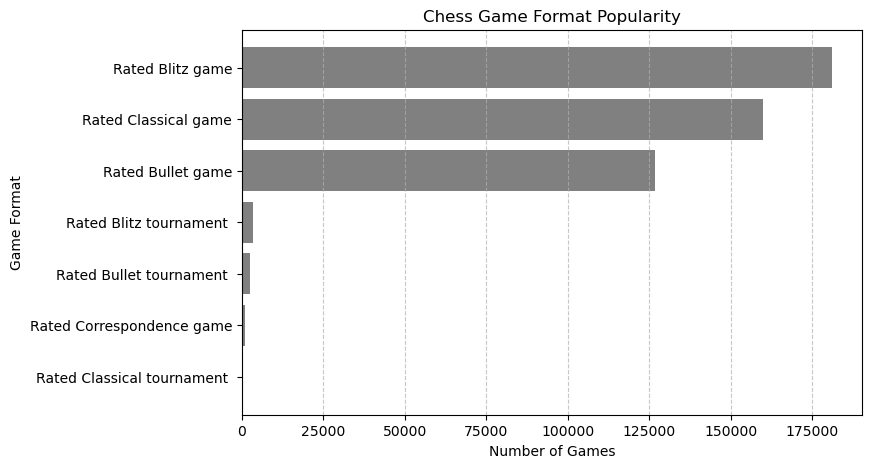

In [18]:
sampled_df.Event = [i[0] for i in sampled_df.Event.str.split("https")] # Remove tournament URLs

print(sampled_df.Event.value_counts())
print("\nThe most popular game format is a", sampled_df.Event.value_counts().keys()[0], "\n")

event_counts = sampled_df.Event.value_counts()
event_names = list(event_counts.keys())
event_values = list(event_counts.values)

# Plotting the data
plt.figure(figsize=(8, 5))
plt.barh(event_names, event_values, color='grey')
plt.xlabel('Number of Games')
plt.ylabel('Game Format')
plt.title('Chess Game Format Popularity')
plt.gca().invert_yaxis()  # Invert y-axis to show highest first
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

In [19]:
print(sampled_df.Result.value_counts())

print("\n",round(sampled_df.Result.value_counts().values[0]/sampled_df.shape[0], 4)*100, 
      "% of games end with white winning")

print("", round(sampled_df.Result.value_counts().values[1]/sampled_df.shape[0], 4)*100, 
      "% of games end with black winning")

print("",round(sampled_df.Result.value_counts().values[2]/sampled_df.shape[0], 4)*100, 
      "% of games end in draws")

Result
1-0        241162
0-1        217997
1/2-1/2     16122
Name: count, dtype: int64

 50.739999999999995 % of games end with white winning
 45.87 % of games end with black winning
 3.39 % of games end in draws


count    474950.000000
mean       1607.369245
std         205.202405
min         782.000000
25%        1472.000000
50%        1602.000000
75%        1741.000000
max        2412.000000
Name: WhiteElo, dtype: float64


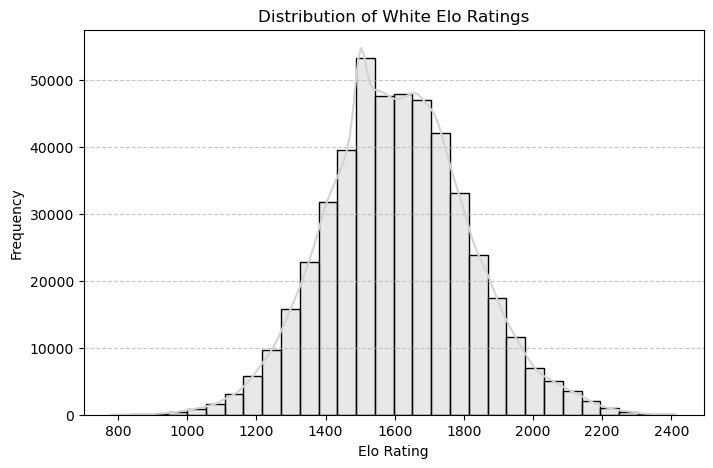

In [20]:
print(sampled_df.WhiteElo.describe())

plt.figure(figsize=(8, 5))
sns.histplot(sampled_df['WhiteElo'], bins=30, kde=True, color='lightgrey', edgecolor='black')

plt.title('Distribution of White Elo Ratings')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

count    474784.000000
mean       1599.834531
std         212.347129
min         789.000000
25%        1461.000000
50%        1592.000000
75%        1737.000000
max        2410.000000
Name: BlackElo, dtype: float64


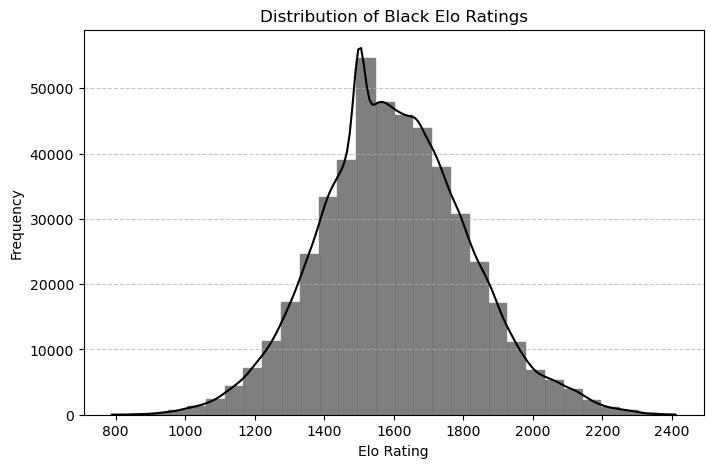

In [21]:
print(sampled_df.BlackElo.describe())

plt.figure(figsize=(8, 5))
sns.histplot(sampled_df['BlackElo'], bins=30, kde=True, color='black', edgecolor='grey')

plt.title('Distribution of Black Elo Ratings')
plt.xlabel('Elo Rating')
plt.ylabel('Frequency')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

**Note:** The peak around 1500 is most likely due to new accounts on [lichess.net](lichess.net) being attributed 1500 elo by default.

In [22]:
print(sampled_df.Opening.value_counts())

print("\n There are", len(sampled_df.Opening.value_counts()), 
      "opening types in total.\n",
     sampled_df.Opening.value_counts().keys()[0], "is the most popular opening.")

Opening
Van't Kruijs Opening                                                      13298
Owen Defense                                                               9995
Scandinavian Defense: Mieses-Kotroc Variation                              8903
Horwitz Defense                                                            8720
Modern Defense                                                             7730
                                                                          ...  
King's Indian Defense: Saemisch Variation, Closed Variation, Main Line        1
King's Gambit Declined: Falkbeer, Charousek Gambit                            1
Italian Game: Scotch Gambit, Max Lange Attack Accepted                        1
King's Indian, Averbakh, Main Line                                            1
Queen's Indian Defense: Yates Variation                                       1
Name: count, Length: 2316, dtype: int64

 There are 2316 opening types in total.
 Van't Kruijs Opening is the mo

In [23]:
## Animation:
visualize_chess_moves(df_games=sampled_df[sampled_df.Opening == sampled_df.Opening.value_counts().keys()[0]], 
                                          game_index=0, num_moves=5)

Extract only the relevant columns for data analysis:

- `Event`: The type of game played
- `WhiteElo`: White ranking
- `BlackElo`: Black ranking
- `ECO`: Opening encoding (ISBN: 978-8672970401)
- `Opening`: Opening text
- `first_10`: PGN of first 10 moves
- `move_11`: PGN of the 11th move
- `Result`: Conclusion of game

In [25]:
df_gamez = sampled_df[["Event", "WhiteElo", "BlackElo", "ECO", "Opening", 
                       "first_10", "move_11", "Result"]] # no "TimeControl"
df_gamez.iloc[0]

Event                                    Rated Classical game
WhiteElo                                               1639.0
BlackElo                                               1403.0
ECO                                                       C00
Opening                      French Defense: Normal Variation
first_10    1. e4 e6 2. d4 b6 3. a3 Bb7 4. Nc3 Nh6 5. Bxh6...
move_11                                               Qf3 Kd8
Result                                                    1-0
Name: 0, dtype: object

In [26]:
# Some more cleaning to do

# Remove move times and evaluations by stockfish (move strength)
def clean_movez(movez):
    cleaned_moves = re.sub(r'\d+\.', '', movez)  # Remove move numbers (like "1.", "2.", etc.)
    cleaned_moves = re.sub(r'[\?\!]+', '', cleaned_moves) # Remove ? and ! for blunders
    cleaned_moves = re.sub(r'\s+', ' ', cleaned_moves).strip() # Remove multiple spaces with a single space
    cleaned_moves = cleaned_moves.replace('..', '') # Remove '..' used for black moves
    return cleaned_moves

df_gamez['first_10_clean'] = df_gamez['first_10'].apply(clean_movez)

/var/folders/n1/pc5lzc7x1q55m1vbsskl4s2c0000gn/T/ipykernel_87086/1884796023.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_gamez['first_10_clean'] = df_gamez['first_10'].apply(clean_movez)


---

## Using PyTorch

In the next step, we try to apply the `PyTorch` library to create a simple transformer that takes the first 10 moves of a given chess game as input and then predicts the 11th move, as visible in our dataset. First, we need the import the necessary packages, extract the data and tokenize it:

In [27]:
import torch

print(f"PyTorch Version: {torch.__version__}")
print(f"Nvidia GPU available: {torch.cuda.is_available()}")
print(f"MPS available: {torch.backends.mps.is_available()}")
print(f"PyTorch MPS built: {torch.backends.mps.is_built()}")

PyTorch Version: 2.5.1
Nvidia GPU available: False
MPS available: True
PyTorch MPS built: True


In [28]:
# Using PyTorch

import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np

# Load the data
first_10_moves = df_gamez['first_10'].values
move_11 = df_gamez['move_11'].values

In [29]:
# Tokenization function - tokenize moves and build a "vocabulary", all_moves
def tokenize_pgn(pgn_moves):
    # Remove numeric move numbers (e.g., "1.", "2.", etc.)
    cleaned_moves = re.sub(r'\d+\.', '', pgn_moves) # Remove move numbers
    cleaned_moves = re.sub(r'[\?\!]+', '', cleaned_moves) # Remove ? and ! for blunders
    cleaned_moves = re.sub(r'\s+', ' ', cleaned_moves).strip() # Remove multiple spaces with a single space
    cleaned_moves = cleaned_moves.replace('..', '') # Remove '..' used for black moves
    return cleaned_moves.split()

all_moves = []
for moves in first_10_moves:
    all_moves.extend(tokenize_pgn(moves))
for move in move_11:
    all_moves.extend(tokenize_pgn(move))
    
print("There are", len(set(all_moves)), "unique moves in the dataset.")

# Create token-to-index mapping
move_counter = Counter(all_moves)
sorted_moves = [move for move, _ in move_counter.most_common()] # Sort moves based on popularity
move_vocab = {move: idx + 1 for idx, move in enumerate(sorted_moves)}
move_vocab['<PAD>'] = 0 # We do not need padding for now, given the fixed length

There are 2122 unique moves in the dataset.


**Note:** Values containing `+` and `*` were only discovered in this part of the analysis - it is important to consider whether moves that classify as "check" or "mate" should be considered as standalone or be grouped together with their ordinary counterparts. For this analysis, we keep them as separate moves due to their importance in the game. Think of it as including an exclamation or a question mark at the end of a word - this can change its significance and meaning wildly.

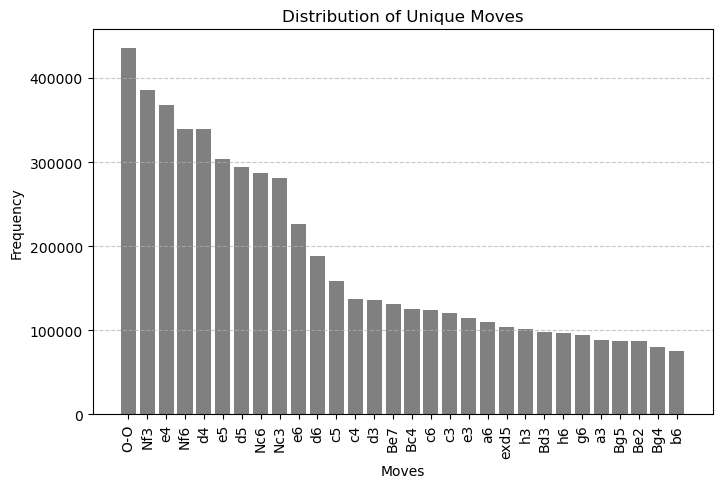

In [31]:
move_names = list(move_counter.keys())
move_frequencies = list(move_counter.values())

sorted_indices = sorted(range(len(move_frequencies)), key=lambda k: move_frequencies[k], reverse=True)
sorted_moves = [move_names[i] for i in sorted_indices]
sorted_frequencies = [move_frequencies[i] for i in sorted_indices]

plt.figure(figsize=(8, 5))
plt.bar(sorted_moves[:30], sorted_frequencies[:30], color = "grey")  # Plot top 30 moves
plt.xlabel('Moves')
plt.ylabel('Frequency')
plt.title('Distribution of Unique Moves')
plt.xticks(rotation=90)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [32]:
# Encode sequences
def encode_moves(moves, max_length=20):
    tokens = tokenize_pgn(moves)
    encoded = [move_vocab.get(move, 0) for move in tokens[:max_length]]
    return encoded + [0] * (max_length - len(encoded))

# Encode first 10 moves and 11th move
X = np.array([encode_moves(moves) for moves in first_10_moves])
y = np.array([encode_moves(move, max_length=2) for move in move_11])  # Predict 2 tokens per move

In [33]:
X # Encoded first 10 moves

array([[  3,  10,   5, ..., 202, 490, 449],
       [  5,   7,   2, ..., 747, 255, 795],
       [  3,   6,   2, ...,   7,  62, 227],
       ...,
       [ 39,   6,  50, ..., 152, 162, 150],
       [  3,   6,   5, ...,  81,  18,  12],
       [ 18,   6,   5, ...,  24, 115,   1]])

In [34]:
y # Encoded 11th move

array([[ 72, 234],
       [481,   8],
       [355, 326],
       ...,
       [ 26,  86],
       [ 87,  32],
       [  2, 102]])

In [35]:
print(y[0]) # First game 11th moves encoded based on their "popularity"
print(move_11[0])
print(move_vocab["Qf3"], move_vocab["Kd8"]) # Match to vector

[ 72 234]
Qf3 Kd8
72 234


In [36]:
# Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

In [37]:
# Create dataset class - PyTorch specific
class ChessDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.long)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]
    
train_dataset = ChessDataset(X_train, y_train)
test_dataset = ChessDataset(X_test, y_test)

# Batch size either 16 or 32
train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # Batch size can be changed later

Now that our data is encoded and in a `PyTorch` conformant format, we can build our neural network. We will use it to predict both the next white and black 11th moves, as the output will consist of two tokens, as seen below:

In [38]:
# Transformer definition
class ChessMovePredictor(nn.Module):
    def __init__(self, 
                 vocab_size, # Total number of unique chess moves (defined in cell below)
                 embed_dim=128,  # Size of the embedding vector
                 num_heads=4, # Number of attention heads in the multi-head attention mechanism
                 hidden_dim=256, # Size of the hidden layer in the feed forward network
                 num_layers=3): # Number of stacked Transformer encoder layers
        super(ChessMovePredictor, self).__init__()
        self.embedding = nn.Embedding(vocab_size, 
                                      embed_dim, # Move indices
                                      padding_idx=0)
        self.transformer = nn.TransformerEncoder(
            nn.TransformerEncoderLayer(d_model=embed_dim, 
                                       nhead=num_heads, 
                                       dim_feedforward=hidden_dim),
            num_layers=num_layers
        )
        # self.fc = nn.Linear(embed_dim, vocab_size) 
        # self.fc = nn.Linear(embed_dim * 3, vocab_size * 2)  
        self.fc = nn.Linear(embed_dim * 20, vocab_size * 2) # First 10 moves - black and white

    def forward(self, x):
        x = self.embedding(x)

        # x = torch.cat((x[:, -3], x[:, -2], x[:, -1]), dim=1)  
        x = torch.cat(( x[:, -20], x[:, -19], x[:, -18], x[:, -17], x[:, -16], x[:, -15], x[:, -14], x[:, -13], x[:, -12], x[:, -11],
            x[:, -10], x[:, -9], x[:, -8], x[:, -7], x[:, -6], x[:, -5], x[:, -4], x[:, -3], x[:, -2], x[:, -1]), dim=1) # First 10 moves
        x = self.fc(x)  # Predict two moves
        
        return x.view(-1, 2, vocab_size)  # Reshape output to [batch_size, 2, vocab_size]

In [39]:
# Model initialization
vocab_size = len(move_vocab)
model = ChessMovePredictor(vocab_size)

/Users/kovy/miniconda3/lib/python3.12/site-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.batch_first was not True(use batch_first for better inference performance)
  warnings.warn(


In [40]:
# Set up the optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # LR can be changed later

In [41]:
# Training loop
# device = torch.device('cpu') # No GPU sadly :D - this was before on Windows
device = torch.device('mps') # Apple Silicon
model.to(device)

ChessMovePredictor(
  (embedding): Embedding(2123, 128, padding_idx=0)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-2): 3 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=128, out_features=128, bias=True)
        )
        (linear1): Linear(in_features=128, out_features=256, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=256, out_features=128, bias=True)
        (norm1): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (norm2): LayerNorm((128,), eps=1e-05, elementwise_affine=True)
        (dropout1): Dropout(p=0.1, inplace=False)
        (dropout2): Dropout(p=0.1, inplace=False)
      )
    )
  )
  (fc): Linear(in_features=2560, out_features=4246, bias=True)
)

In [42]:
def train_model(model, train_loader, epochs=10): # number of epochs can be changed later
    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            optimizer.zero_grad()
            output = model(inputs)
            
            # loss = criterion(output, targets[:, 0])  # Predict first token of move_11
            loss_white = criterion(output[:, 0, :], targets[:, 0])  # Loss for White move
            loss_black = criterion(output[:, 1, :], targets[:, 1])  # Loss for Black move
            loss = loss_white + loss_black
            
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        print(f"Epoch {epoch+1}, Loss: {total_loss / len(train_loader)}")

train_model(model, train_loader)

Epoch 1, Loss: 9.157165757174283
Epoch 2, Loss: 7.0265178544175
Epoch 3, Loss: 6.292208791340949
Epoch 4, Loss: 5.882939145001593
Epoch 5, Loss: 5.613711526289149
Epoch 6, Loss: 5.4187997885573855
Epoch 7, Loss: 5.268449480957785
Epoch 8, Loss: 5.1521733959923885
Epoch 9, Loss: 5.054743691669372
Epoch 10, Loss: 4.9754671837480515


In [43]:
# Evaluate the model for both White and Black moves
def evaluate_model(model, test_loader):
    model.eval()
    correct_white = 0
    correct_black = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)  # Output shape: [batch_size, 2, vocab_size]

            predicted_white = torch.argmax(output[:, 0, :], dim=1)  # White move prediction
            predicted_black = torch.argmax(output[:, 1, :], dim=1)  # Black move prediction

            correct_white += (predicted_white == targets[:, 0]).sum().item()
            correct_black += (predicted_black == targets[:, 1]).sum().item()
            total += targets.size(0)

    white_acc = correct_white / total * 100
    black_acc = correct_black / total * 100

    print(f"White Move Accuracy: {white_acc:.2f}%")
    print(f"Black Move Accuracy: {black_acc:.2f}%")
    print(f"Overall Accuracy: {(correct_white + correct_black) / (2 * total) * 100:.2f}%")

# Call the evaluation function
evaluate_model(model, test_loader) # With over 900 thousand moves

White Move Accuracy: 24.75%
Black Move Accuracy: 14.36%
Overall Accuracy: 19.56%


... we can see that the model preforms with quite low accuracy (especially for the second, black move), we can also test this out on individual chess games:

In [44]:
model.eval()
with torch.no_grad():
    # Encode the sample moves (picking a specific game)
    sample_moves = torch.tensor([encode_moves(df_gamez.first_10_clean.iloc[21])])  # Pick any game
    sample_moves = sample_moves.to(device)

    # Get model predictions (output shape: [1, 2, vocab_size])
    predicted_move = model(sample_moves)

    # Extract predicted indices for both White and Black moves
    predicted_white_index = torch.argmax(predicted_move[:, 0, :], dim=1).item()
    predicted_black_index = torch.argmax(predicted_move[:, 1, :], dim=1).item()

    # Convert predicted indices back to move strings
    white_move = list(move_vocab.keys())[list(move_vocab.values()).index(predicted_white_index)]
    black_move = list(move_vocab.keys())[list(move_vocab.values()).index(predicted_black_index)]

    print(f"Predicted next moves:\n White: {white_move}\n Black: {black_move}")

Predicted next moves:
 White: h3
 Black: Bxf3


In [45]:
print(df_gamez.first_10.iloc[21])
print("11.", df_gamez.move_11.iloc[21])

1. e4 d5 2. exd5 Qxd5 3. Nc3 Qe6+ 4. Qe2 Nf6 5. Nf3 b6 6. d3 h6 7. Qxe6 Bxe6 8. Be2 Nbd7 9. O-O Bg4 10. Bf4 Rc8
11. Nb5 Nd5


In [46]:
visualize_chess_moves(df_gamez, 21, 10)

... in this scenario, the model sometimes also suggests a move that is *impossible/illegal* - we will demonstrate this later more rigorously.

## Accuracy vs. Data Size

As proven time and time again in the literature and practice, transofmers are especially effective when trained on huge data sets - we can put this to the test by training the transformer above on subsets of the same data varying in size.

In [47]:
# This function needs to be adjusted for evaluation - changing dataset size

# Evaluate the model for both White and Black moves
def evaluate_model_acc(model, test_loader):
    model.eval()
    correct_white = 0
    correct_black = 0
    total = 0

    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            output = model(inputs)  # Output shape: [batch_size, 2, vocab_size]

            predicted_white = torch.argmax(output[:, 0, :], dim=1)  # White move prediction
            predicted_black = torch.argmax(output[:, 1, :], dim=1)  # Black move prediction

            correct_white += (predicted_white == targets[:, 0]).sum().item()
            correct_black += (predicted_black == targets[:, 1]).sum().item()
            total += targets.size(0)

    white_acc = correct_white / total * 100
    black_acc = correct_black / total * 100

    print(f"White Move Accuracy: {white_acc:.2f}%")
    print(f"Black Move Accuracy: {black_acc:.2f}%")
    print(f"Overall Accuracy: {(correct_white + correct_black) / (2 * total) * 100:.2f}%")
    
    return ((correct_white + correct_black) / (2 * total)), white_acc, black_acc

# Call the evaluation function
evaluate_model_acc(model, test_loader)

White Move Accuracy: 24.75%
Black Move Accuracy: 14.36%
Overall Accuracy: 19.56%


(0.19556687040407333, 24.754620911663526, 14.358753169151143)

In [ ]:
accuracy_scores = []
white_accuracy_scores = []
black_accuracy_scores = []
movez_no = []

for i in range(2000, 400000, 20000):
    
    # print("For size:", i)
    
    df_gamez_x = df_gamez.iloc[0:i]

    first_10_moves = df_gamez_x['first_10'].values
    move_11 = df_gamez_x['move_11'].values

    all_moves = []
    for moves in first_10_moves:
        all_moves.extend(tokenize_pgn(moves))
    for move in move_11:
        all_moves.extend(tokenize_pgn(move))

    # print("There are", len(set(all_moves)), "unique moves in the dataset.")

    # Create token-to-index mapping
    move_counter = Counter(all_moves)
    sorted_moves = [move for move, _ in move_counter.most_common()]
    move_vocab = {move: idx + 1 for idx, move in enumerate(sorted_moves)}
    move_vocab['<PAD>'] = 0 # We do not need padding for now, given the fixed length

    X = np.array([encode_moves(moves) for moves in first_10_moves])
    y = np.array([encode_moves(move, max_length=2) for move in move_11])  # Predict 2 tokens per move

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

    train_dataset = ChessDataset(X_train, y_train)
    test_dataset = ChessDataset(X_test, y_test)

    # Batch size either 16 or 32
    train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False) # Smaller batch size

    # Model initialization
    vocab_size = len(move_vocab)
    model = ChessMovePredictor(vocab_size)

    # Set up the optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    # device = torch.device('cpu') 
    device = torch.device('mps') # Apple Silicon
    model.to(device)

    train_model(model, train_loader)
    evaluate_model_acc(model, test_loader)
    
    # Append
    accuracy_scores.append(evaluate_model_acc(model, test_loader)[0])
    white_accuracy_scores.append(evaluate_model_acc(model, test_loader)[1])
    black_accuracy_scores.append(evaluate_model_acc(model, test_loader)[2])

    movez_no.append(all_moves) # Number of unique
    
    # print("\n")
    
# print(accuracy_scores)

**Note:** The code above took roughly 1 day to run, *with* a GPU capacity.

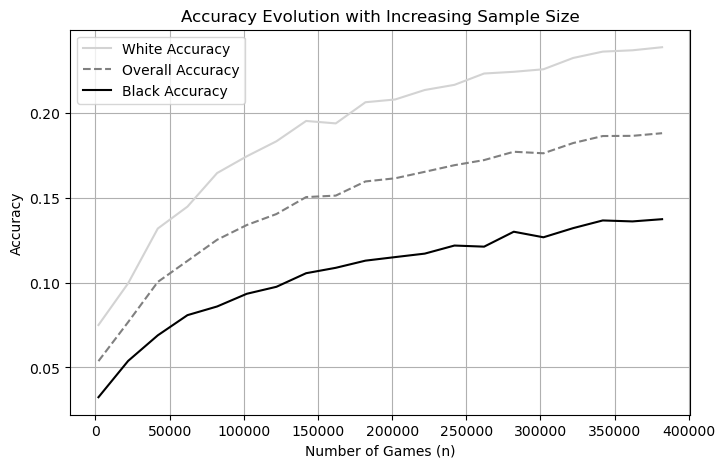

In [50]:
df_acc = pd.DataFrame({"n": [i for i in range(2000, 400000, 20000)],
                       "acc": accuracy_scores,
                       "white_acc": [i/100 for i in white_accuracy_scores],
                       "black_acc": [i/100 for i in black_accuracy_scores]})

# Lineplot
plt.figure(figsize=(8, 5))
plt.plot(df_acc['n'], df_acc['white_acc'], label='White Accuracy', color='lightgrey') # marker='o'
plt.plot(df_acc['n'], df_acc['acc'], label='Overall Accuracy', color='grey', linestyle='--')
plt.plot(df_acc['n'], df_acc['black_acc'], label='Black Accuracy', color='black')

plt.xlabel('Number of Games (n)')
plt.ylabel('Accuracy')
plt.title('Accuracy Evolution with Increasing Sample Size')
plt.legend()
plt.grid(True)
plt.show()

As visible from the plot above, the overall accuracy of the prediction of the 11th move increases with sample size gradually, but with *diminishing returns.* As we reach the limit of what is possible with our hardware capacity, the overall accuracy of the 11th move prediction hovers below **20 %** as the curve slowly flattens.

White move accuracy (maxing out below **25 %** is consistently higher than black move accuracy (**15 %** max), as the latter is contingent on a wider number of possibilities given that it is second in line. The vocabulary size, i.e., the number of available moves, while not displayed explicitly in the plot above, also increases incrementally, at a similar rate with the prediction accuracy in line with expectations.

## Legality Checks

In [59]:
model.eval()
with torch.no_grad():
    # Encode the sample moves (picking a specific game)
    sample_moves = torch.tensor([encode_moves(df_gamez.first_10_clean.iloc[42])])  # Pick any game
    sample_moves = sample_moves.to(device)

    # Get model predictions (output shape: [1, 2, vocab_size])
    predicted_move = model(sample_moves)

    # Extract predicted indices for both White and Black moves
    predicted_white_index = torch.argmax(predicted_move[:, 0, :], dim=1).item()
    predicted_black_index = torch.argmax(predicted_move[:, 1, :], dim=1).item()

    # Convert predicted indices back to move strings
    white_move = list(move_vocab.keys())[list(move_vocab.values()).index(predicted_white_index)]
    black_move = list(move_vocab.keys())[list(move_vocab.values()).index(predicted_black_index)]

    print(f"Predicted next moves:\n White: {white_move}\n Black: {black_move}")

Predicted next moves:
 White: gxf3
 Black: Nf6


In [60]:
print(df_gamez.first_10.iloc[42])
print("11.", df_gamez.move_11.iloc[42])

1. d4 Nc6 2. e3 d5 3. Bd3 Bf5 4. Bd2 e6 5. Nf3 Bxd3 6. cxd3 Bb4 7. e4 Bxd2+ 8. Kxd2 dxe4 9. dxe4 Nxd4 10. Nc3 Nxf3+
11. Ke2 Nd4+


In [179]:
visualize_chess_moves(df_gamez, 42, 10)

In [62]:
board = chess.Board()
for move in df_gamez.first_10_clean.iloc[42].split():
    board.push_san(move)
    
print(board.is_legal(board.parse_san(white_move))) # White move is illegal !
print(board.is_legal(board.parse_san(black_move)))
print(board)

IllegalMoveError: illegal san: 'gxf3' in r2qk1nr/ppp2ppp/4p3/8/4P3/2N2n2/PP1K1PPP/R2Q3R w kq - 0 11

... as visible from the error above, the transformer also struggles with predicting stricly legal moves. In this case, it is because it fails to understand that the king is in check and, therefore, other pieces on the board are not allowed to move until the check gets resolved.

----

## Adjusting other parameters

Sample size (`n`) is not the only criterion that can be adjusted in order to see how well the model can perform. Other parameters in the transformer's setup, such as `lr`, `batch_size` and `n_epochs` can be equally important to its performance. In this section, we will apply these changes at a fixed dataset volume (`n` = 200k entries) to see how the accuracy changes under these different condition.

### Learning Rate  

The learning rate (`lr`) is one of the most crucial hyperparameters in training a neural network, as it dictates how much the model updates its weights with each optimization step. A **high learning rate** can speed up training but risks overshooting optimal values, leading to instability or divergence. Conversely, a **low learning rate** ensures more precise updates but may result in slow convergence or getting stuck in local minima. In this section, we experiment with different learning rates to analyze their impact on model accuracy, keeping the dataset size fixed at **200k entries**.

In [ ]:
# Lists to store results
accuracy_scores = []
white_accuracy_scores = []
black_accuracy_scores = []
movez_no = []
learning_rates = [0.1, 0.01, 0.001, 0.0005, 0.0001]  # Different LR values

# Fixed dataset size
i = 200000  
df_gamez_x = df_gamez.iloc[0:i]

# Extract moves
first_10_moves = df_gamez_x['first_10'].values
move_11 = df_gamez_x['move_11'].values

# Tokenization and Vocabulary Creation
all_moves = [move for moves in first_10_moves for move in tokenize_pgn(moves)]
all_moves += [move for move in move_11 for move in tokenize_pgn(move)]

# print("There are", len(set(all_moves)), "unique moves in the dataset.")

# Create token-to-index mapping without Counter
unique_moves = list(set(all_moves))  # Get unique moves
move_vocab = {move: idx + 1 for idx, move in enumerate(unique_moves)}
move_vocab['<PAD>'] = 0  # Padding token

# Encode moves
X = np.array([encode_moves(moves) for moves in first_10_moves])
y = np.array([encode_moves(move, max_length=2) for move in move_11])  # Predict 2 tokens per move

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

train_dataset = ChessDataset(X_train, y_train)
test_dataset = ChessDataset(X_test, y_test)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False)

# Device setup
device = torch.device('mps')  # Apple Silicon
vocab_size = len(move_vocab)

# Iterate over different learning rates
for lr in learning_rates:
    # print(f"\nTraining with Learning Rate: {lr}")

    # Initialize model
    model = ChessMovePredictor(vocab_size).to(device)
    
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Train model
    train_model(model, train_loader)
    
    # Evaluate model
    overall_acc, white_acc, black_acc = evaluate_model_acc(model, test_loader)
    
    # Store results
    accuracy_scores.append(overall_acc)
    white_accuracy_scores.append(white_acc)
    black_accuracy_scores.append(black_acc)
    movez_no.append(all_moves)

# print("\nFinal Results:")
#for i, lr in enumerate(learning_rates):
    #print(f"LR: {lr} -> Overall Acc: {accuracy_scores[i]}, White Acc: {white_accuracy_scores[i]}, Black Acc: {black_accuracy_scores[i]}")

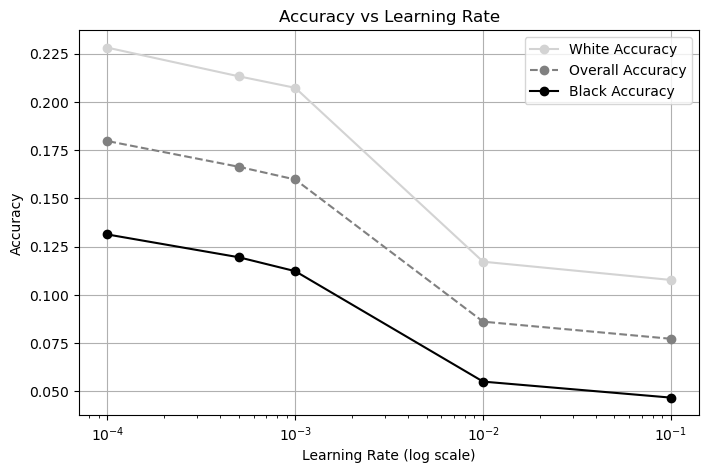

In [73]:
# Learning Rate Plot
df_lr = pd.DataFrame({
    "lr": [0.1, 0.01, 0.001, 0.0005, 0.0001],
    "acc": accuracy_scores,
    "white_acc": [i / 100 for i in white_accuracy_scores],
    "black_acc": [i / 100 for i in black_accuracy_scores]
})

plt.figure(figsize=(8, 5))
plt.plot(df_lr['lr'], df_lr['white_acc'], label='White Accuracy', color='lightgrey', marker='o')
plt.plot(df_lr['lr'], df_lr['acc'], label='Overall Accuracy', color='grey', linestyle='--', marker='o')
plt.plot(df_lr['lr'], df_lr['black_acc'], label='Black Accuracy', color='black', marker='o')

plt.xscale("log")
plt.xlabel('Learning Rate (log scale)')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Learning Rate')
plt.legend()
plt.grid(True)
plt.show()

The relationship between accuracy and learning rate follows a clear **downward trend**, indicating that *higher learning rates lead to significantly worse accuracy*. When the learning rate is too high (e.g., `0.1` or `0.01`), the model struggles to converge, resulting in poor predictions. At **moderate values** (`0.001`), the accuracy is noticeably better, suggesting that this is a more stable range for learning. The best results occur at **lower learning rates** (`0.0005` and `0.0001`), where the model achieves its highest accuracy. However, while very low learning rates can help the model converge smoothly, they may also lead to **longer training times** without substantial performance gains - this is why we chose `lr = 0.001` in the analysis with changing sample sizes above as well.

### Batch Size

Batch size determines how many samples the model processes before updating its weights. A **small batch size** (e.g., 16 or 32) allows for more frequent updates, which can help the model generalize better but may result in noisier gradient updates. A **larger batch size** (e.g., 128 or 256) provides more stable gradient estimates but requires more memory and may converge to a poorer local minimum. In this section, we experiment with different batch sizes to analyze their impact on model accuracy, keeping the dataset size fixed at 200k entries and the learning rate fixed at 0.001.

In [ ]:
# Lists to store results
accuracy_scores = []
white_accuracy_scores = []
black_accuracy_scores = []
movez_no = []
batch_sizes = [8, 16, 32, 64, 128]  # Different batch sizes
learning_rate = 0.001  # Fixed learning rate

# Fixed dataset size
i = 200000  
df_gamez_x = df_gamez.iloc[0:i]

# Extract moves
first_10_moves = df_gamez_x['first_10'].values
move_11 = df_gamez_x['move_11'].values

# Tokenization and Vocabulary Creation
all_moves = [move for moves in first_10_moves for move in tokenize_pgn(moves)]
all_moves += [move for move in move_11 for move in tokenize_pgn(move)]

# print("There are", len(set(all_moves)), "unique moves in the dataset.")

# Create token-to-index mapping without Counter
unique_moves = list(set(all_moves))  # Get unique moves
move_vocab = {move: idx + 1 for idx, move in enumerate(unique_moves)}
move_vocab['<PAD>'] = 0  # Padding token

# Encode moves
X = np.array([encode_moves(moves) for moves in first_10_moves])
y = np.array([encode_moves(move, max_length=2) for move in move_11])  # Predict 2 tokens per move

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

train_dataset = ChessDataset(X_train, y_train)
test_dataset = ChessDataset(X_test, y_test)

# Device setup
device = torch.device('mps')  # Apple Silicon
vocab_size = len(move_vocab)

# Iterate over different batch sizes
for batch_size in batch_sizes:
    # print(f"\nTraining with Batch Size: {batch_size}")

    # Create DataLoaders with varying batch sizes
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    # Initialize model
    model = ChessMovePredictor(vocab_size).to(device)
    
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train model
    train_model(model, train_loader)
    
    # Evaluate model
    overall_acc, white_acc, black_acc = evaluate_model_acc(model, test_loader)
    
    # Store results
    accuracy_scores.append(overall_acc)
    white_accuracy_scores.append(white_acc)
    black_accuracy_scores.append(black_acc)
    movez_no.append(all_moves)

#print("\nFinal Results:")
#for i, batch_size in enumerate(batch_sizes):
 #   print(f"Batch Size: {batch_size} -> Overall Acc: {accuracy_scores[i]}, White Acc: {white_accuracy_scores[i]}, Black Acc: {black_accuracy_scores[i]}")

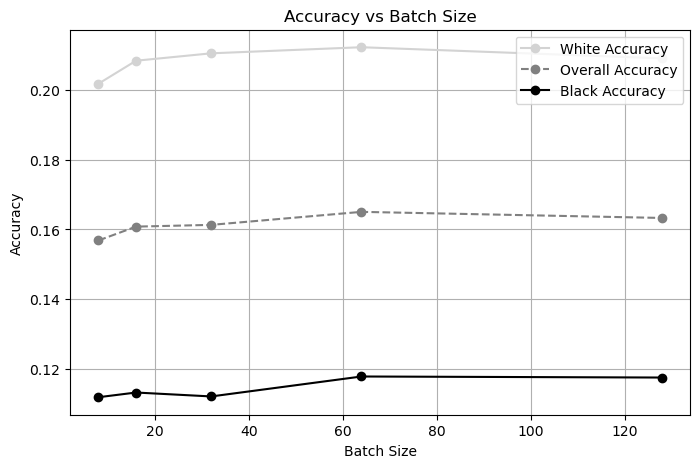

In [75]:
# Batch Size Plot
df_bs = pd.DataFrame({
    "batch_size": [8, 16, 32, 64, 128],
    "acc": accuracy_scores,
    "white_acc": [i / 100 for i in white_accuracy_scores],
    "black_acc": [i / 100 for i in black_accuracy_scores]
})

plt.figure(figsize=(8, 5))
plt.plot(df_bs['batch_size'], df_bs['white_acc'], label='White Accuracy', color='lightgrey', marker='o')
plt.plot(df_bs['batch_size'], df_bs['acc'], label='Overall Accuracy', color='grey', linestyle='--', marker='o')
plt.plot(df_bs['batch_size'], df_bs['black_acc'], label='Black Accuracy', color='black', marker='o')

plt.xlabel('Batch Size')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Batch Size')
plt.legend()
plt.grid(True)
plt.show()

Batch size seems to be circumstantial at best when it comes to its effect on accuracy - be it white, black or overall.

### Number of Epochs  

The number of epochs (`n_epochs`) determines how many times the model iterates over the entire dataset during training. **Fewer epochs** (e.g., 5 or 10) may result in **underfitting**, where the model hasn't learned enough patterns from the data. **More epochs** (e.g., 20 or 25) allow the model to train longer, but this can lead to **overfitting**, where the model memorizes the training data instead of generalizing well to new data. In this section, we experiment with different epoch values to analyze their impact on model accuracy, keeping the dataset size at **200k entries**, batch size at **32**, and learning rate at **0.001**.

In [ ]:
# Lists to store results
accuracy_scores = []
white_accuracy_scores = []
black_accuracy_scores = []
movez_no = []
epoch_values = [5, 10, 20, 25]  # Different epoch values
learning_rate = 0.001  # Fixed learning rate
batch_size = 32  # Fixed batch size

# Fixed dataset size
i = 200000  
df_gamez_x = df_gamez.iloc[0:i]

# Extract moves
first_10_moves = df_gamez_x['first_10'].values
move_11 = df_gamez_x['move_11'].values

# Tokenization and Vocabulary Creation
all_moves = [move for moves in first_10_moves for move in tokenize_pgn(moves)]
all_moves += [move for move in move_11 for move in tokenize_pgn(move)]

# print("There are", len(set(all_moves)), "unique moves in the dataset.")

# Create token-to-index mapping without Counter
unique_moves = list(set(all_moves))  # Get unique moves
move_vocab = {move: idx + 1 for idx, move in enumerate(unique_moves)}
move_vocab['<PAD>'] = 0  # Padding token

# Encode moves
X = np.array([encode_moves(moves) for moves in first_10_moves])
y = np.array([encode_moves(move, max_length=2) for move in move_11])  # Predict 2 tokens per move

# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=21)

train_dataset = ChessDataset(X_train, y_train)
test_dataset = ChessDataset(X_test, y_test)

# Create DataLoaders with fixed batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Device setup
device = torch.device('mps')  # Apple Silicon
vocab_size = len(move_vocab)

# Iterate over different epoch values
for n_epochs in epoch_values:
    # print(f"\nTraining with Number of Epochs: {n_epochs}")

    # Initialize model
    model = ChessMovePredictor(vocab_size).to(device)
    
    # Set up optimizer and loss function
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

    # Train model for different epoch values
    train_model(model, train_loader, epochs=n_epochs)  # Pass num_epochs parameter
    
    # Evaluate model
    overall_acc, white_acc, black_acc = evaluate_model_acc(model, test_loader)
    
    # Store results
    accuracy_scores.append(overall_acc)
    white_accuracy_scores.append(white_acc)
    black_accuracy_scores.append(black_acc)
    movez_no.append(all_moves)

#print("\nFinal Results:")
#for i, n_epochs in enumerate(epoch_values):
 #   print(f"Epochs: {n_epochs} -> Overall Acc: {accuracy_scores[i]}, White Acc: {white_accuracy_scores[i]}, Black Acc: {black_accuracy_scores[i]}")

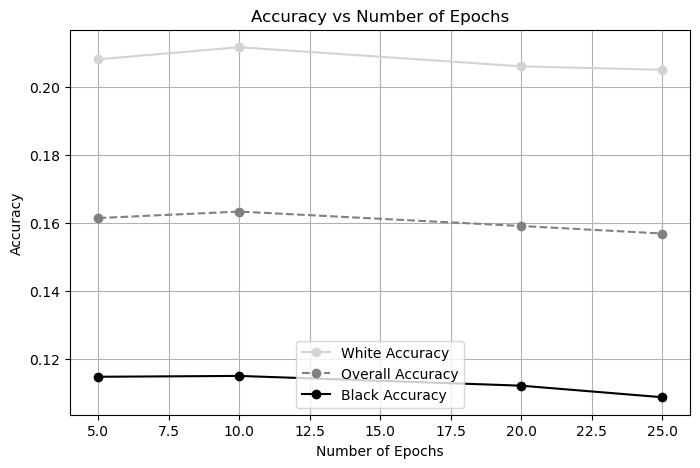

In [79]:
# Number of Epochs Plot
df_epochs = pd.DataFrame({
    "epochs": [5, 10, 20, 25],
    "acc": accuracy_scores,
    "white_acc": [i / 100 for i in white_accuracy_scores]
    "black_acc": [i / 100 for i in black_accuracy_scores]
})

plt.figure(figsize=(8, 5))
plt.plot(df_epochs['epochs'], df_epochs['white_acc'], label='White Accuracy', color='lightgrey', marker='o')
plt.plot(df_epochs['epochs'], df_epochs['acc'], label='Overall Accuracy', color='grey', linestyle='--', marker='o')
plt.plot(df_epochs['epochs'], df_epochs['black_acc'], label='Black Accuracy', color='black', marker='o')

plt.xlabel('Number of Epochs')
plt.ylabel('Accuracy')
plt.title('Accuracy vs Number of Epochs')
plt.legend()
plt.grid(True)
plt.show()

... for the number of epochs, the same can be said as for batch size - the effect on accuracy is marginal. 

---

## Confusion Matrix

To better understand how well the model predicts chess moves, we generate a **confusion matrix**, which compares the model’s predictions against the actual moves. This allows us to see which moves are consistently predicted correctly and where the model struggles.  

Since the full confusion matrix is extremely large, we extract and display a **subset** focusing on the **20** most frequently predicted moves. The leading question here is: *Which moves does the model get consistenly right?* ... or **wrong**...

In [115]:
from sklearn.metrics import confusion_matrix

model.eval()
all_preds = [] 
all_labels = []

with torch.no_grad():
    for X_batch, y_batch in test_loader: 
        X_batch, y_batch = X_batch.to(device), y_batch.to(device) # GPU
        predicted_moves = model(X_batch) # Predictions
        predicted_white_indices = torch.argmax(predicted_moves[:, 0, :], dim=1)  # White move predictions
        predicted_black_indices = torch.argmax(predicted_moves[:, 1, :], dim=1)  # Black move predictions

        batch_preds = torch.stack((predicted_white_indices, predicted_black_indices), dim=1) # Stack

        # Move tensors to CPU in bulk before converting to NumPy (reduces GPU->CPU transfer overhead)
        all_preds.append(batch_preds.cpu().numpy())
        all_labels.append(y_batch.cpu().numpy())
        
all_preds = np.concatenate(all_preds, axis=0)  # Shape (40000, 2)
all_labels = np.concatenate(all_labels, axis=0)  # Shape (40000, 2)

# Invert move_vocab to map indices to move names
index_to_move = {v: k for k, v in move_vocab.items()}
def map_indices_to_moves(array):
    return np.array([[index_to_move.get(w, f"UNK({w})"), index_to_move.get(b, f"UNK({b})")] for w, b in array])
all_preds_moves = map_indices_to_moves(all_preds)
all_labels_moves = map_indices_to_moves(all_labels)

# Converted values from tokens to movetext
print("Sample Mapped Predictions:\n", all_preds_moves[:5])
print("Sample Mapped Labels:\n", all_labels_moves[:5])

Sample Mapped Predictions:
 [['g4' 'Bg4']
 ['Be3' 'Qxe7']
 ['Ne6' 'f4']
 ['Nh5' 'Be7']
 ['Nc3' 'g4']]
Sample Mapped Labels:
 [['h5' 'Bf5']
 ['Bxe6' 'fxe6']
 ['Ndb5' 'Bd6']
 ['h3' 'Bxf4']
 ['Nc3' 'd6']]


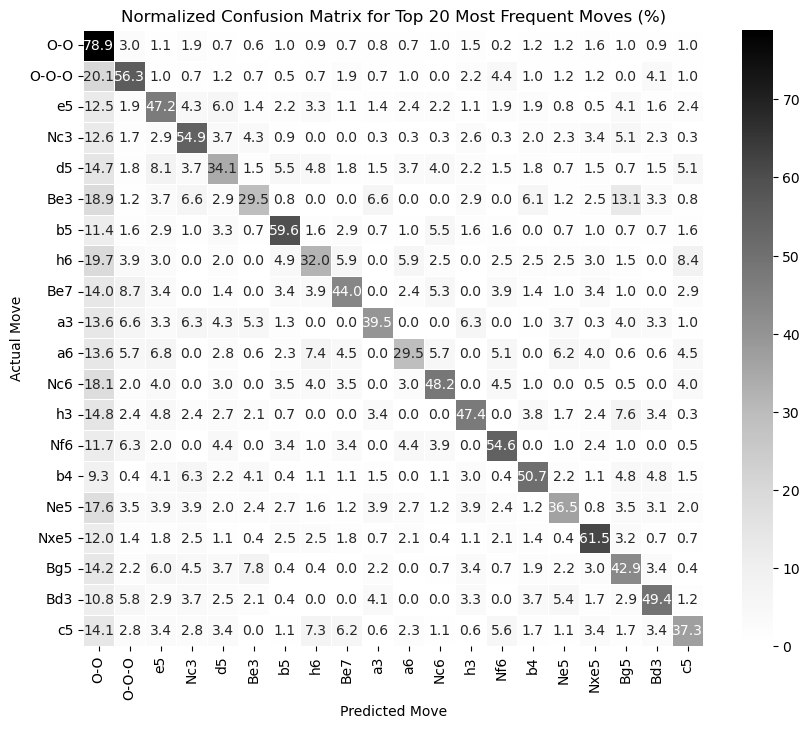

In [118]:
# Display confusion matris
flat_preds = all_preds_moves.flatten()
flat_labels = all_labels_moves.flatten()

# Compute value counts
move_counts = pd.Series(flat_labels).value_counts()
top_moves = move_counts.head(20).index.tolist()

# skleanr confusion matrix
conf_matrix = confusion_matrix(flat_labels, flat_preds, labels=top_moves)
conf_matrix_percent = conf_matrix.astype(float) / conf_matrix.sum(axis=1, keepdims=True) * 100  # add %
df_conf_matrix = pd.DataFrame(conf_matrix_percent, index=top_moves, columns=top_moves)

# Plot
plt.figure(figsize=(10, 8))
sns.heatmap(df_conf_matrix, annot=True, fmt=".1f", cmap="Greys", linewidths=0.5) # chess color
plt.xlabel("Predicted Move")
plt.ylabel("Actual Move")
plt.title(f"Normalized Confusion Matrix for Top {N} Most Frequent Moves (%)")
plt.show()

The learnings from this plot are quite significant - the by far most correctly predicted move in the dataset is `O-O` (short castle), which also happens to be the most common one. This move seems to be quite overused by the model, as suggested by the darker shade of the leftmost column in the confusion matrix. The transformer seems to suggest castling more often than is actually the case.

Other popular moves that are identified correctly are `Nxe5` (knight to e5) and `b5` (pawn to b5). The move among the top 20 moves with the least correct predictions is `Be3`, bishop to e3, a fairly popular move, along with `a6`, pawn to a6.

In [184]:
df_gamez_viz_last = df_gamez.copy(deep=False)
df_gamez_viz_last["first_10_list"] = df_gamez_viz_last["first_10_clean"].str.split(" ")

required_moves = {'O-O', 'Nxe5', 'b5', 'Be3', 'a6'}
df_gamez_viz_last = df_gamez_viz_last[df_gamez_viz_last['first_10_list'].apply(lambda x: required_moves.issubset(x))]
df_gamez_viz_last = df_gamez_viz_last.reset_index().drop("index", axis=1)
df_gamez_viz_last

,Event,WhiteElo,BlackElo,ECO,Opening,first_10,move_11,Result,first_10_clean,first_10_list
0,Rated Blitz game,1688.0,1729.0,B50,Sicilian Defense,1. e4 c5 2. Nf3 d6 3. Bc4 e6 4. c3 Nf6 5. d3 B...,Bb3 Qc7,1-0,e4 c5 Nf3 d6 Bc4 e6 c3 Nf6 d3 Be7 O-O O-O e5 d...,"[e4, c5, Nf3, d6, Bc4, e6, c3, Nf6, d3, Be7, O..."
1,Rated Bullet game,1564.0,1606.0,C30,"King's Gambit Declined, Queen's Knight Defense",1. e4 e5 2. f4 Nc6 3. Nf3 d6 4. Bc4 h6 5. O-O ...,Bd5 c6,1-0,e4 e5 f4 Nc6 Nf3 d6 Bc4 h6 O-O a6 fxe5 Nxe5 Nx...,"[e4, e5, f4, Nc6, Nf3, d6, Bc4, h6, O-O, a6, f..."
2,Rated Bullet game,1939.0,1722.0,B30,Sicilian Defense: Nyezhmetdinov-Rossolimo Attack,1. e4 c5 2. Nf3 Nc6 3. Bb5 Qc7 4. O-O e6 5. c3...,f4 Bd6,1-0,e4 c5 Nf3 Nc6 Bb5 Qc7 O-O e6 c3 a6 Ba4 b5 Bc2 ...,"[e4, c5, Nf3, Nc6, Bb5, Qc7, O-O, e6, c3, a6, ..."
3,Rated Classical game,1596.0,1461.0,C24,Bishop's Opening: Berlin Defense,1. e4 e5 2. Bc4 Nf6 3. d3 a6 4. Bg5 Be7 5. Nf3...,f3 d6,1-0,e4 e5 Bc4 Nf6 d3 a6 Bg5 Be7 Nf3 b5 Bb3 h6 Be3 ...,"[e4, e5, Bc4, Nf6, d3, a6, Bg5, Be7, Nf3, b5, ..."
4,Rated Blitz game,1715.0,2026.0,B40,Sicilian Defense: French Variation,1. e4 c5 2. Nf3 e6 3. Bb5 a6 4. Be2 b5 5. Nc3 ...,Bf3 Qc7,0-1,e4 c5 Nf3 e6 Bb5 a6 Be2 b5 Nc3 Bb7 d3 d6 Be3 N...,"[e4, c5, Nf3, e6, Bb5, a6, Be2, b5, Nc3, Bb7, ..."
5,Rated Bullet game,1526.0,1652.0,B30,Sicilian Defense: Old Sicilian,1. e4 c5 2. Nf3 Nc6 3. Bc4 e6 4. d3 a6 5. O-O ...,h3 Nf6,0-1,e4 c5 Nf3 Nc6 Bc4 e6 d3 a6 O-O b5 Bb3 Bb7 Nc3 ...,"[e4, c5, Nf3, Nc6, Bc4, e6, d3, a6, O-O, b5, B..."
6,Rated Classical game,1516.0,1202.0,C68,Ruy Lopez: Exchange Variation,1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Bxc6 dxc6 5. ...,Ne2 c5,1-0,e4 e5 Nf3 Nc6 Bb5 a6 Bxc6 dxc6 Nxe5 Bd6 Nf3 Nf...,"[e4, e5, Nf3, Nc6, Bb5, a6, Bxc6, dxc6, Nxe5, ..."
7,Rated Blitz game,1793.0,1664.0,B20,Sicilian Defense: Bowdler Attack,1. e4 c5 2. Bc4 Nc6 3. c3 e6 4. d3 a6 5. Be3 b...,d4 cxd4,0-1,e4 c5 Bc4 Nc6 c3 e6 d3 a6 Be3 b5 Bb3 Qc7 Nf3 f...,"[e4, c5, Bc4, Nc6, c3, e6, d3, a6, Be3, b5, Bb..."
8,Rated Classical game,1560.0,1524.0,B20,Sicilian Defense: Bowdler Attack,1. e4 c5 2. Bc4 d6 3. Nf3 a6 4. Nc3 e6 5. d3 B...,O-O-O Bxg2,0-1,e4 c5 Bc4 d6 Nf3 a6 Nc3 e6 d3 Be7 Be3 b5 Bb3 N...,"[e4, c5, Bc4, d6, Nf3, a6, Nc3, e6, d3, Be7, B..."
9,Rated Classical game,1620.0,1948.0,C77,"Ruy Lopez: Morphy Defense, Anderssen Variation",1. e4 e5 2. Nf3 Nc6 3. Bb5 a6 4. Ba4 Nf6 5. d3...,O-O d5,0-1,e4 e5 Nf3 Nc6 Bb5 a6 Ba4 Nf6 d3 Bc5 Be3 Nd4 Nx...,"[e4, e5, Nf3, Nc6, Bb5, a6, Ba4, Nf6, d3, Bc5,..."


Interestingly, there are only *two* games in our dataset that contain these exact five moves in the first 10 black and white moves. Very often, this is a **Sicilian Defense**, a rather tough style of game to predict with many, many variations, making it quite hard for the transformer. Here is one of them visualised:

In [185]:
visualize_chess_moves(df_gamez_viz_last, 0, 10)

---

## Other analysis possibilities

As we move towards the limit of what is possible for us with our time and hardware constraints, I would simply like to list a number of different directions this projects could possibly head in in the future, building on the foundation contained in this notebook:

- Predicting **more than one move** into the future: Given that the transformer could theoretically be fully capable to generate more than two resulting tokens by adjusting the `self.fc = nn.Linear(embed_dim * 20, vocab_size * 2)` further up in the notebook, we could theoretically use it to predict further and further into chess games, and eventually, towards their ending as well. However, as we have seen with the significantly lower black move accuracy above, the model would likely struggle with lower and lower precision levels as the game went on.
- Predicting **checkmate**: Speaking of moving further into games, the model could be tweaked to identify when a game is over, based on not only NLP methods, but building on a stringent set of rules to specify the criteria in order for this to happen. This would mean that the model would know when to stop generating next moves when correctly identifying checkmate patterns.
- Predicting the game **winner**: Additionally, the adjacent metadata included in the dataset could be combined with the `movetext` column in order to predict whether white or black would win a given game based on a fixed amount of initial moves, along with the possibility of accounting for draws as well.

Who knows - maybe this project will find its stride in the future to be expanded into the areas mentioned above.

---

# Conclusion

Transformers have proven to be incredibly effective at generating natural language and *predicting the next word*, so to speak. The same can be said about the **next move** in chess games. It is very important to stress that the aim of this project was not to predict the **best move** - there are other engines such as [Stockfish](https://stockfishchess.org) that excel at this aim already and go way beyond what is my capacity in this assignment. The aim of the project is to generate a model that faithfully attempts to recreate the *most likely next move* based on a large amount of chess games ranging from complete *noobs* to *experts* on publicly available data on [lichess.org](lichess.org). This was attempted by collecting a large amount of data from this platform, processing it in a form that individual moves could be separated, tokenized and fed into a transformer model in `PyTorch` that could, upon receiving a 10-move sequence, predict the 11th white and black moves that would be *most likely* in a given scenario. Key lessons:

- **Sample Size**: Increasing the number of training games significantly improved the model's accuracy, with diminishing returns at higher volumes, indicating that while more data helps, the model benefits most from the initial increase in sample size.
- **Learning Rate**: The best accuracy was achieved at **lower learning rates**, while higher learning rates (while faster) led to unstable training and poor predictions.
- **Batch Size** & **Number of Epochs**: Both of these parameters have had little to no effect on the accuracy of predictions.

Of course, one most not forget the problem with predicting illegal moves, such as when the king is in check, or the possibility of taking the analysis further to predict outcomes of games based on NLP methods combined with standard ML techniques on the other metadata in the dataset.